# Practical session: Machine Learning Applications 

## Application of machine learning for the discovery of transcription factor binding sites (TFBS)

This tutorial has been developed using the original file and supplement to the manuscript, **A Primer on Deep Learning in Genomics** (*Nature Genetics, 2018*) by James Zou, Mikael Huss, Abubakar Abid, Pejman Mohammadi, Ali Torkamani & Amalio Telentil. [Read the accompanying paper here](https://www.nature.com/articles/s41588-018-0295-5).

Find the original tutorial in the Github site [here](https://github.com/abidlabs/deep-learning-genomics-primer/tree/master) or available as a jupyter notebook in Google Colab: <a href="https://colab.research.google.com/github/abidlabs/deep-learning-genomics-primer/blob/master/A_Primer_on_Deep_Learning_in_Genomics_Public.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

To check that the correct environment is activated, load the following libraries

In [8]:
## load some modules to test the environment works appropriately
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import sklearn
import tensorflow as tf

## Load modules
from tensorflow.keras.layers import Conv1D, Dense, MaxPooling1D, Flatten
from tensorflow.keras.models import Sequential

## 0. Background

In this practical, we will show how to use deep learning to approach an important problem in functional genomics: **the discovery of transcription-factor binding sites in DNA**.

As we go through this notebook, we will  design a [neural network](https://www.geeksforgeeks.org/neural-networks-a-beginners-guide/?ref=gcse) that can discover binding motifs in DNA based on the results of an assay that determines whether a longer DNA sequence binds to the protein or not. Here, the longer **DNA sequences are our *independent variables*** (or *predictors*), while the **positive or negative response of the assay is the *dependent variable* (or *response*)**.

We will use simulated data that consists of DNA sequences of length 50 bases (chosen to be artificially short so that the data is easy to play around with), and is labeled with 0 or 1 depending on the result of the assay. Our goal is to build a classifier that can predict whether a particular sequence will bind to the protein and discover the short motif that is the binding site in the sequences that are bound to the protein.

(Spoiler alert: the true regulatory motif is *`CGACCGAACTCC`*. Of course, the neural network doesn't know this.)


## 1. Curate the Data

We will split the data into three different sub-datasets:

**(1) Training dataset**: a dataset used to fit the parameters of a model or to define the weights of connections between neurons of a neural network.

**(2) Validation dataset**: a second dataset used to minimize overfitting. The weights of the network are not adjusted with this data set. After each training cycle, if the accuracy over the training data set increases, but the accuracy over the validation data set stays the same or decreases, then there is overfitting on the neural network.

**(3) Testing dataset**: is a third dataset not included in the training nor validation data sets. After all the training and validation cycles are complete, this dataset is used only for testing the final solution in order to measure the actual predictive power of the neural network on new examples.




We start by loading the simulated data from the original repository

In [9]:
SEQUENCES_URL = 'https://raw.githubusercontent.com/abidlabs/deep-learning-genomics-primer/master/sequences.txt'
sequences = requests.get(SEQUENCES_URL).text.split('\n')

# This removes empty sequences if any
sequences = list(filter(None, sequences))  
len(sequences)

2000

#### 2b) Hot-one encode all sequences 

In [10]:
# just load modules and create objects again just in case
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
integer_encoder = LabelEncoder()  
one_hot_encoder = OneHotEncoder(categories='auto') 

In [11]:
## 2) one-hot encode the simulated DNA sequence
input_features = []
for sequence in sequences:
    if len(sequence) == 0:
        print("Stop")
    integer_encoded = integer_encoder.fit_transform(list(sequence))
    integer_encoded = np.array(integer_encoded).reshape(-1, 1)
    one_hot_encoded = one_hot_encoder.fit_transform(integer_encoded)
    input_features.append(one_hot_encoded.toarray())

## convert to numpy array
np.set_printoptions(threshold=40)
input_features = np.stack(input_features)

In [12]:
## show another example of the encoding
print("Example sequence\n-----------------------")
print('DNA Sequence #1:\n',sequences[0][:10],'...',sequences[0][-10:])
print('One hot encoding of Sequence #1:\n',input_features[0].T)

Example sequence
-----------------------
DNA Sequence #1:
 CCGAGGGCTA ... CGCGGACACC
One hot encoding of Sequence #1:
 [[0. 0. 0. ... 1. 0. 0.]
 [1. 1. 0. ... 0. 1. 1.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [13]:
input_features.shape # (examples, sequence, base)

(2000, 50, 4)

The _input_features_ is the object containing the information from DNA sequences one-hot encoded to use as input for the neural network. It is stored as tensor (numpy array)

#### 3) Get information for each sequence

In [14]:
## download information from original website
LABELS_URL = 'https://raw.githubusercontent.com/abidlabs/deep-learning-genomics-primer/master/labels.txt'

labels = requests.get(LABELS_URL).text.split('\n')
labels = list(filter(None, labels))  # removes empty sequences

labels = np.array(labels).reshape(-1, 1)
input_labels = one_hot_encoder.fit_transform(labels).toarray()

print('Labels:\n',labels.T)
print('One-hot encoded labels:\n',input_labels.T)

Labels:
 [['0' '0' '0' ... '0' '1' '1']]
One-hot encoded labels:
 [[1. 1. 1. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 1.]]


### Prepare the training and test sets

In [15]:
## load package and split the input information: sequences and labels, as tensors
from sklearn.model_selection import train_test_split

train_features, test_features, train_labels, test_labels = train_test_split(
    input_features, input_labels, test_size=0.25, random_state=123)

In [ ]:
#######################################
## create a function to reproduce the model many times
#######################################

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

def train_and_evaluate(model, features, labels, epochs=10, test_percentage=0.2, validation_percentage=0.25):
    
    if model.history:
        
        print("Model has already been trained. Interrupting training...")
        return
    
    ## split the dataset
    train_features, test_features, train_labels, test_labels = train_test_split(
        features, labels, test_size=test_percentage)

    ## train
    history = model.fit(train_features, train_labels, 
                    epochs=epochs, verbose=0, validation_split=validation_percentage)
    
    
    ## evaluate
    loss_and_metrics = model.evaluate(test_features, test_labels, verbose=0)
    
    print('Accuracy (test set)',loss_and_metrics[1])
    
    
    predicted_labels = model.predict(np.stack(test_features))
    cm = confusion_matrix(np.argmax(test_labels, axis=1), 
                          np.argmax(predicted_labels, axis=1))
    cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]

    ## create plots
    create_plots(history, cm)

    


In [35]:
#######################################
## create plots model
#######################################

import itertools
def create_plots(history2use_here, cm_given):
    
    # Initialise the subplot function using number of rows and columns
    figure, axis = plt.subplots(1, 3, figsize=(12, 6))    
    
    ## plot the results training as LOSS curve
    axis[0].plot(history2use_here.history['loss'])
    axis[0].plot(history2use_here.history['val_loss'])
    axis[0].set_title('model loss')
    axis[0].set_ylabel('loss')
    axis[0].set_xlabel('epoch')
    axis[0].legend(['train', 'validation'])
    
    ## plot accuracy curve
    axis[1].plot(history2use_here.history['binary_accuracy'])
    axis[1].plot(history2use_here.history['val_binary_accuracy'])
    axis[1].set_title('model accuracy')
    axis[1].set_ylabel('accuracy')
    axis[1].set_xlabel('epoch')
    axis[1].legend(['train', 'validation'])
    
    #figure.legend(['train', 'validation'], loc='outside right upper')

    ## plot the confusion matrix for True/False observed/predicted
    axis[2].imshow(cm_given, cmap=plt.cm.Blues)
    axis[2].set_title('Normalized confusion matrix')
    axis[2].set_xlabel('True label')
    axis[2].set_ylabel('Predicted label')
    axis[2].set_xticks([0, 1]); 
    axis[2].set_yticks([0, 1])
    axis[2].grid('off')
    for i, j in itertools.product(range(cm_given.shape[0]), range(cm_given.shape[1])):
        axis[2].text(j, i, format(cm_given[i, j], '.2f'),
                 horizontalalignment='center',
                 color='white' if cm_given[i, j] > 0.5 else 'black')

    
    # Combine all the operations and display
    plt.show()

## Question 1:
The verbose parameter decides wether a visualisation of the current progress is shown during training. It can be set to:
0 > no process shown
1 > process bar
2 > prints a summary line after each epoch. (details like loss and metrics)

## Question 2:
Reducing the dense layers from 16 to 10 does not decrease the share of correctly predicted labels shown in the normalized confusion matrix.
However the loss is higher and increases over the iterations (epoches). Additionally the model accuracy does not reach the same level for training versus validation data. However this difference is very small, ranging around 3 percentage points.

Accuracy (test set) 0.7200000286102295
16/16 [==============================] - 0s 2ms/step


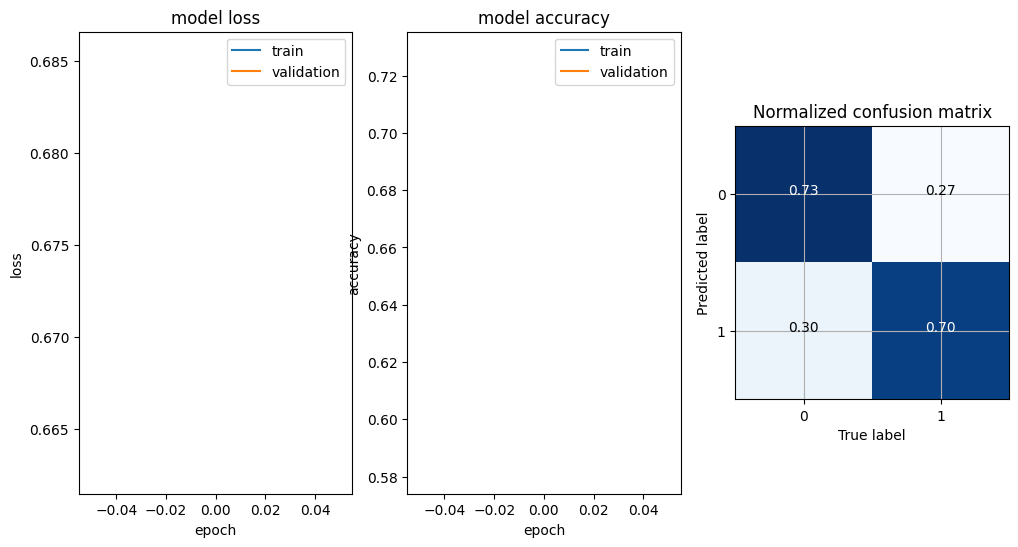

Model has already been trained. Iterrupting training...


In [40]:
# Q2 code
model_CNN_HW = Sequential()
model_CNN_HW.add(Conv1D(filters=32, kernel_size=12, 
                 input_shape=(input_features.shape[1], 4)))
model_CNN_HW.add(MaxPooling1D(pool_size=4))
model_CNN_HW.add(Flatten())
model_CNN_HW.add(Dense(10, activation='relu')) ## reduced from 16 to 10 
model_CNN_HW.add(Dense(2, activation='softmax'))

model_CNN_HW.compile(loss='binary_crossentropy', optimizer='adam', 
              metrics=['binary_accuracy'])

train_and_evaluate(model_CNN_HW, input_features, input_labels, epochs=1, test_percentage=0.25)
train_and_evaluate(model_CNN_HW, input_features, input_labels, epochs=10, test_percentage=0.25)

In [ ]:
model_CNN_HW.summary() 

In [ ]:
model_CNN_HW.compile(loss='binary_crossentropy', optimizer='adam', 
             metrics=['binary_accuracy'])

layers10_CNN = model_CNN_HW.fit(train_features, train_labels, 
                    epochs=50, verbose=0, validation_split=0.25)

In [ ]:
# analysis of performance with only 10 dense layers
create_plots(layers10_CNN, cm_given=cm)

## Question 3:
Effect of changing epoch: Lower epoch values do not decrease the share of corretly predicted labels shown in the normalized confusion matrix.
Higher epoch values lead to the function needing more time. Model loss and model accuracy for the validation data increased with higher epoche values.


In [ ]:
model_CNN_HW = Sequential()
model_CNN_HW.add(Conv1D(filters=32, kernel_size=12, 
                 input_shape=(train_features.shape[1], 4)))
model_CNN_HW.add(MaxPooling1D(pool_size=4))
model_CNN_HW.add(Flatten())
model_CNN_HW.add(Dense(16, activation='relu'))
model_CNN_HW.add(Dense(2, activation='softmax'))

model_CNN_HW.compile(loss='binary_crossentropy', optimizer='adam', 
             metrics=['binary_accuracy'])

epoch2 = model_CNN_HW.fit(train_features, train_labels, 
                    epochs=2, verbose=0, validation_split=0.25)
create_plots(epoch2, cm_given=cm)

In [ ]:
model_CNN_HW = Sequential()
model_CNN_HW.add(Conv1D(filters=32, kernel_size=12, 
                 input_shape=(train_features.shape[1], 4)))
model_CNN_HW.add(MaxPooling1D(pool_size=4))
model_CNN_HW.add(Flatten())
model_CNN_HW.add(Dense(16, activation='relu'))
model_CNN_HW.add(Dense(2, activation='softmax'))

model_CNN_HW.compile(loss='binary_crossentropy', optimizer='adam', 
             metrics=['binary_accuracy'])

epoch1000 = model_CNN_HW.fit(train_features, train_labels, 
                    epochs=1000, verbose=0, validation_split=0.25)
create_plots(epoch1000, cm_given=cm)

In [ ]:
model_CNN_HW = Sequential()
model_CNN_HW.add(Conv1D(filters=32, kernel_size=12, 
                 input_shape=(train_features.shape[1], 4)))
model_CNN_HW.add(MaxPooling1D(pool_size=4))
model_CNN_HW.add(Flatten())
model_CNN_HW.add(Dense(16, activation='relu'))
model_CNN_HW.add(Dense(2, activation='softmax'))

model_CNN_HW.compile(loss='binary_crossentropy', optimizer='adam', 
             metrics=['binary_accuracy'])

epoch100 = model_CNN_HW.fit(train_features, train_labels, 
                    epochs=100, verbose=0, validation_split=0.25)
create_plots(epoch100, cm_given=cm)

## Question 4: 
Higher share of validation data decreases model loss on validation data. Normalized confusion matrix stays unchanged

In [ ]:
# code Q4
test75 = model_CNN.fit(train_features, train_labels, 
                    epochs=50, verbose=0, validation_split=0.75)
create_plots(test75, cm_given=cm)

In [ ]:
# code Q4
test50 = model_CNN.fit(train_features, train_labels, 
                    epochs=50, verbose=0, validation_split=0.5)
create_plots(test50, cm_given=cm)

## Questions to address:

- Find what is the effect of the verbose parameter in the _model.fit()_ [or supplied as _verb_2use_ the _example_CNN()_]
- Test the effect of applying a more simple model [Hint: reduce layers of the model]
- Test the effect of epoch in the prediction: 2, 5, 10, 25, 50, 100, 1000
- Test the effect of applying a different test/train set partition


## 5. Interpret the results

![alt text](https://github.com/abidlabs/deep-learning-genomics-primer/blob/master/Screenshot%20from%202018-08-01%2020-32-31.png?raw=true)

Your results so far should allow you to conclude that the neural network is quite effective in learning to distinguish sequences that bind the protein from sequences that do not. But can we understand _why_ the neural network classifies a training point in the way that it does? To do so, we can compute a simple _saliency map_, which is the gradient of the model's prediction with respect to each individual nucleotide. 

In other words, the saliency maps shows how the output response value changes with respect to a small changes in input nucleotide sequence. All the positive values in the gradients tell us that a small change to that nucleotide will change the output value. Hence, visualizing these gradients for a given input sequence, should provide some clues about what nucleotides form the binding motive that we are trying to identify.

In [ ]:
#import tensorflow.keras.backend as K
import keras.backend as K

def compute_salient_bases(model, x):
    @tf.function
    def compute_gradients(x):
        with tf.GradientTape() as tape:
            tape.watch(x)
            logits = model(x)
            prob = logits[:, 1]  # Assuming binary classification, change the index if needed
        gradients = tape.gradient(prob, x)
        return gradients

    x_value = np.expand_dims(x, axis=0)
    gradients = compute_gradients(x_value)
    gradients = tf.where(gradients == None, tf.zeros_like(gradients), gradients)
    sal = tf.reduce_sum(gradients * x, axis=2)
    sal = tf.clip_by_value(sal, clip_value_min=0, clip_value_max=tf.reduce_max(sal))
    return sal.numpy()

In [ ]:
## Positive sequence
sequence_index = 1999  
sal = compute_salient_bases(model_CNN, input_features[sequence_index])

plt.figure(figsize=[16,5])
barlist = plt.bar(np.arange(len(sal[0])), sal[0])
[barlist[i].set_color('C1') for i in range(5,17)]  # Change the coloring here if you change the sequence index.
plt.xlabel('Bases')
plt.ylabel('Magnitude of saliency values')
plt.xticks(np.arange(len(sal[0])), list(sequences[sequence_index]));
plt.title('Saliency map for bases in one of the positive sequences'
          ' (orange indicates the actual bases in motif)');

In [ ]:
# negative sequence
sequence_index = 0  
sal = compute_salient_bases(model_CNN, input_features[sequence_index])

plt.figure(figsize=[16,5])
barlist = plt.bar(np.arange(len(sal[0])), sal[0])
[barlist[i].set_color('C1') for i in range(5,17)]  # Change the coloring here if you change the sequence index.
plt.xlabel('Bases')
plt.ylabel('Magnitude of saliency values')
plt.xticks(np.arange(len(sal[0])), list(sequences[sequence_index]));
plt.title('Saliency map for bases in one of the negative sequences'
          ' (orange indicates the actual bases in motif)');

The results above should show high saliency values for the bases _CGACCGAACTCC_ appearing in the DNA sequence. If you recall from the top of the document, this is exactly the motif that we embedded in the positive sequences! The raw saliency values may be non-zero for other bases as well -- the gradient-based saliency map method is not perfect, and there other more complex interpretation methods that are used in practice to obtain better results.  

Furthermore, we may explore other architectures for our neural network to see if we can improve performance on the validation dataset. For example, we could choose different _hyper-parameters_, which are variables that define the network structure (e.g. the number of dense or convolutional layers, the dimensionality of each layer, etc.) and variables that determine how the network is trained (e.g. the number of epochs, the learning rate, etc.). Testing different hyper-parameter values or performing a hyper-parameter search grid are good practices that may help the deep learning procedure to obtain a clearer signal for classifying sequences and identifying the binding motif.

## Acknowledgements 

Thanks to Julia di lulio and Raquel Dias for helpful comments and suggestions in preparing this notebook.

## References and examples
- https://www.kdnuggets.com/2018/05/wtf-tensor.html
- https://www.geeksforgeeks.org/implementing-neural-networks-using-tensorflow/ 
- https://www.geeksforgeeks.org/neural-networks-a-beginners-guide/?ref=gcse
- https://wandb.ai/mostafaibrahim17/ml-articles/reports/A-Deep-Dive-Into-Learning-Curves-in-Machine-Learning--Vmlldzo0NjA1ODY0
- https://machinelearningmastery.com/binary-classification-tutorial-with-the-keras-deep-learning-library/
- https://www.bmc.com/blogs/keras-neural-network-classification/

# GitHub Repository

If you found this tutorial helpful, kindly star the [associated GitHub repo](https://github.com/abidlabs/deep-learning-genomics-primer/blob/master/A_Primer_on_Deep_Learning_in_Genomics_Public.ipynb) so that it is more visible to others as well!